# Prepare Environment

In [1]:
import scanpy as sc
import pytometry as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from joblib import Parallel, delayed

In [3]:
%load_ext cython

In [4]:
BASE = 'G:\\My Drive\\colab\\cytometry\\2022_Nature_Becher\\surface_panel\\batch_1\\'
fls = sorted(os.listdir(BASE))
fls.pop(0)
first = fls[0]

In [5]:
fpath = BASE + first
adata = pm.io.read_fcs(fpath)

In [6]:
sc.pp.subsample(adata, 0.1)

In [7]:
adata

AnnData object with n_obs × n_vars = 10834 × 36
    var: 'Channel Number', 'marker', '$PnD', '$PnB', '$PnR', 'channel', '$PnG', '$PnE'
    uns: 'meta'

In [8]:
sc.pp.neighbors(adata)

In [9]:
from scipy.stats import entropy
from scipy.special import softmax
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import vstack, hstack
from scanpy.tools._umap import umap
import joblib
from typing import Union, Optional, Literal
_InitPos = Literal['paga', 'spectral', 'random']
AnyRandom = Union[None, int, np.random.RandomState]
HELPER_VAR = {}

In [10]:
%%time
class _Scale:
    def __init__(self, X=None, T=None, I=None, W=None, P=None, X_humap=None, lm_ind=None, parent_scale=None):
        self.X = X
        self.T = T
        self.I = I
        self.W = W
        self.P = P
        self.X_humap = X_humap
        self.lm_ind = lm_ind
        self.parent_scale = parent_scale

CPU times: total: 0 ns
Wall time: 0 ns


Declaring and Checking Arguments

In [11]:
%%time
imp_channel_ind=None
beta=100
beta_thresh=1.5
teta=50
num_scales=1
min_dist= 0.5
spread= 1.0
n_components= 2
maxiter= None
alpha= 1.0
gamma= 1.0
negative_sample_rate= 5
init_pos='spectral'
random_state= 0
a= None
b= None
copy= False
method= 'umap'
neighbors_key= None

if imp_channel_ind is None:
    imp_channel_ind = range(len(adata.var_names))
elif len(imp_channel_ind) == 0:
    imp_channel_ind = range(len(adata.var_names))

# settings dict for all important setting variables
parameters = {
    'beta': beta,
    'beta_thresh': beta_thresh,
    'teta': teta,
    'imp_channel_ind' : imp_channel_ind}

try:
    adata.obsp['distances']
except KeyError as e:
    raise Exception("k-nearest-neighbor graph has to be constructed first")
distances_nn = adata.obsp['distances']

scale_list = list()

CPU times: total: 0 ns
Wall time: 1 ms


In [12]:
adata.uns['humap_settings'] = parameters
adata.uns['humap_scales'] = scale_list

In [13]:
adata

AnnData object with n_obs × n_vars = 10834 × 36
    var: 'Channel Number', 'marker', '$PnD', '$PnB', '$PnR', 'channel', '$PnG', '$PnE'
    uns: 'meta', 'neighbors', 'humap_settings', 'humap_scales'
    obsp: 'distances', 'connectivities'

## Helpers

In [14]:
def _helper_method_calc_T(dist):
    from scipy.special import softmax
    d = dist / np.max(dist)
    return softmax((-d ** 2) / _binary_search_sigma(d, len(d)))

def _binary_search_sigma(d, n_neigh):
    # binary search
    import numpy as np
    sigma = 10  # Start Sigma
    goal = np.log(n_neigh)  # log(k) with k being n_neighbors
    # Do binary search until entropy ~== log(k)
    while True:
        ent = entropy(softmax((-d ** 2) / sigma))
        # check sigma
        if np.isclose(ent, goal):
            return sigma
        if ent > goal:
            sigma *= 0.5
        else:
            sigma /= 0.5

def _helper_method_AoI(state):
    # load globals
    T = HELPER_VAR['T']
    lm = HELPER_VAR['lm']
    reached_lm = np.zeros(len(lm))

    cache = list()  # create empty cache list
    cache.append(state)  # append initial state vector as first element
    state_len = np.shape(state)[1]  # get length of vector once

    # do until minimal landmark-"hit"-count is reached (--> landmarks_left < 0)
    landmarks_left = HELPER_VAR['min_lm']
    while landmarks_left >= 0:
        # erg_random_walk = -1
        step = 1
        while True:
            if len(cache) <= step:
                cache.append(cache[step - 1] * T)
            erg_random_walk = np.random.choice(state_len, p=cache[step].toarray()[0])
            if erg_random_walk in lm:
                reached_lm[lm.index(erg_random_walk)] += 1
                landmarks_left -= 1
                break
            step += 1
    erg = reached_lm / np.sum(reached_lm.data)
    return csr_matrix(erg)

def _helper_method_T_next_mul_W(i):
    # load globals
    W = HELPER_VAR['W']
    num_lm_s_prev = HELPER_VAR['num_lm_s_prev']
    return csr_matrix(np.reshape(i.toarray().reshape((num_lm_s_prev,)) * W, (num_lm_s_prev, 1)))

def _helper_method_T_next_row_div(r):
    return r[1] / np.sum(r[1])

def _helper_method_get_landmarks(state):
    for i in range(HELPER_VAR['teta']):
        state *= HELPER_VAR['T']
    destinations = np.random.choice(range(HELPER_VAR['n_events']), HELPER_VAR['beta'], p=state.toarray()[0])
    hits = np.zeros((HELPER_VAR['n_events']))
    for d in destinations:
        hits[d] += 1
    return [(h[0], h[1]) for h in enumerate(hits) if h[1] > 0]

## 1.1 Root Scale

In [15]:
dim = distances_nn.shape[0]
settings = parameters

In [16]:
# Create first scale
s_root = _Scale(X=adata.X[:,imp_channel_ind], W=1)

In [17]:
%%time
probs = map(_helper_method_calc_T, [dist.data for dist in distances_nn])
data = []
for pr in probs:
    data.extend(pr)
T = csr_matrix((data, distances_nn.indices, distances_nn.indptr), shape=(dim,dim))
s_root.T = T

CPU times: total: 2.64 s
Wall time: 2.66 s


In [18]:
%%time
P = T + T.transpose() - T.multiply(T.transpose())
s_root.P = P

CPU times: total: 31.2 ms
Wall time: 20 ms


In [19]:
tmpdata = sc.AnnData(s_root.X)
tmpdata.obsp['connectivities'] = s_root.P
tmpdata.obsm['X_pca'] = s_root.X
tmpdata.uns['neighbors'] = {
    'params':{'method':'umap'},
    'connectivities_key':'connectivities'
}

In [20]:
%%time
umap(
    tmpdata,
    min_dist=min_dist,
    spread=spread,
    n_components=n_components,
    maxiter=maxiter,
    alpha=alpha,
    gamma=gamma,
    negative_sample_rate=negative_sample_rate,
    init_pos=init_pos,
    random_state=random_state,
    a=a,
    b=b,
    copy=False,
    method=method,
    neighbors_key=neighbors_key)
X_humap = tmpdata.obsm['X_umap'].copy()
s_root.X_humap = X_humap

CPU times: total: 16.9 s
Wall time: 16.7 s


In [21]:
n_events = T.shape[0]
proposals = np.zeros(n_events)  # counts how many times point has been reached
landmarks = list()  # list of landmarks
HELPER_VAR = {'T': T,
              'teta': settings['teta'],
              'beta': settings['beta'],
              'beta_thresh': settings['beta_thresh'],
              'n_events': n_events}

In [22]:
%%time
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])

CPU times: total: 500 ms
Wall time: 496 ms


Below cell is a bottleneck. It use non-parallel nested for loops

### Parallelize the bottleneck part

In [28]:
def temp_func(state_hits, proposals):
    for h in state_hits:
        proposals[h[0]] += h[1]

In [30]:
%%time
_ = Parallel(n_jobs=8)(delayed(temp_func)(state_hits, proposals) for state_hits in hit_list)

CPU times: total: 4min 30s
Wall time: 4min 37s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

TODO:
what if compile parallelized??
Or compile firt parallelize then?

### Original result evalution which is bottleneck

In [23]:
%%time
# evaluate results
for state_hits in hit_list:
    for h in state_hits:
        proposals[h[0]] += h[1]

CPU times: total: 7min 39s
Wall time: 7min 41s


landmark collection

In [24]:
%%time
min_beta = settings['beta'] * settings['beta_thresh']
for prop in enumerate(proposals):
    # if event has been hit min_beta times, it counts as landmark
    if prop[1] > min_beta:
        landmarks.append(prop[0])

s_root.lm_ind = landmarks

CPU times: total: 0 ns
Wall time: 2 ms


In [25]:
scale_list.append(s_root)

## 1.2 Remaining Scales

In [26]:
s_prev = scale_list[0]

In [27]:
s_curr = _Scale(X=s_prev.X[s_prev.lm_ind, :], parent_scale=s_prev)

In [28]:
%%time
scale = s_prev
min_lm = 100

n_events = scale.T.shape[0]
# create state matrix containing all initial states
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))

HELPER_VAR = {'lm': scale.lm_ind, 'min_lm': min_lm, 'T': scale.T}
I = map(_helper_method_AoI, [s for s in init_states])
I = vstack(I)
s_curr.I = I

CPU times: total: 16min 20s
Wall time: 16min 23s


In [29]:
%%time
I = s_curr.I
W_old = s_prev.W
if type(W_old) is int: #W_old is None or W_old is 1:
    W_old = np.ones((I.shape[0],))
W_s = np.array(W_old * I).reshape((I.shape[1]))
s_curr.W = W_s

CPU times: total: 0 ns
Wall time: 2 ms


In [30]:
%%time
I = s_curr.I
W = s_prev.W

num_lm_s_prev, num_lm_s = (I.shape[0],I.shape[1])  # dimensionst of I
# num_lm_s_old > num_lm_s
I_t = I.transpose()  # transposed Influence matrix

HELPER_VAR = {'W': W, 'num_lm_s_prev': num_lm_s_prev}

I_with_W = map(_helper_method_T_next_mul_W, [it for it in I_t])
I_with_W = hstack(list(I_with_W))
I = I_with_W.T * I
T_next = map(_helper_method_T_next_row_div, enumerate(I))

T_next = vstack(T_next)
T_next = T_next.tocsr()
s_curr.T = T_next

CPU times: total: 2 s
Wall time: 2.01 s


In [31]:
%%time
T = s_curr.T
settings = parameters
n_events = T.shape[0]
proposals = np.zeros(n_events)  # counts how many times point has been reached
landmarks = list()  # list of landmarks

HELPER_VAR = {'T': T, 'teta': settings['teta'], 'beta': settings['beta'], 
              'beta_thresh': settings['beta_thresh'], 'n_events': n_events}
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])
# evaluate results
for state_hits in hit_list:  # for every states hit_list
    for h in state_hits:  # for every hit in some states hit_list
        proposals[h[0]] += h[1]
# collect landmarks
min_beta = settings['beta'] * settings['beta_thresh']
for prop in enumerate(proposals):
    # if event has been hit min_beta times, it counts as landmark
    if prop[1] > min_beta:
        landmarks.append(prop[0])
s_curr.lm_ind = landmarks

CPU times: total: 4min 38s
Wall time: 4min 39s


t-SNE Symmetrization

In [32]:
%%time
T = s_curr.T
P = (T + T.transpose()) / (2 * T.shape[0])
s_curr.P = P

CPU times: total: 46.9 ms
Wall time: 44 ms


Umap Symmetrization

In [33]:
%%time
T = s_curr.T
P = T + T.transpose() - T.multiply(T.transpose())
s_curr.P = P

CPU times: total: 78.1 ms
Wall time: 83 ms


In [34]:
tmpdata = sc.AnnData(X=s_curr.X)
tmpdata.obsp['connectivities'] = s_curr.P
tmpdata.obsm['X_pca'] = s_curr.X
tmpdata.uns['neighbors'] = {'params':{'method':'umap'}}
tmpdata.uns['neighbors']['connectivities_key'] = 'connectivities'

In [35]:
%%time
umap(
     tmpdata,
     min_dist=min_dist,
     spread=spread,
     n_components=n_components,
     maxiter=maxiter,
     alpha=alpha,
     gamma=gamma,
     negative_sample_rate=negative_sample_rate,
     init_pos=init_pos,
     random_state=random_state,
     a=a,
     b=b,
     copy=False,
     method=method,
     neighbors_key=neighbors_key)
X_humap = tmpdata.obsm['X_umap']
s_curr.X_humap = X_humap

CPU times: total: 3.72 s
Wall time: 3.78 s


In [36]:
scale_list.append(s_curr)

## 1.3 Third Iteration (Level 3)

In [37]:
len(scale_list)

2

In [38]:
s_prev = scale_list[1]
s_curr = _Scale(X=s_prev.X[s_prev.lm_ind, :], parent_scale=s_prev)

In [39]:
%%time
scale = s_prev
min_lm = 100

n_events = scale.T.shape[0]
# create state matrix containing all initial states
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
HELPER_VAR = {'lm': scale.lm_ind, 'min_lm': min_lm, 'T': scale.T}
I = map(_helper_method_AoI, [s for s in init_states])
I = vstack(I)
s_curr.I = I

CPU times: total: 2min
Wall time: 2min


In [40]:
%%time
I = s_curr.I
W_old = s_prev.W
if type(W_old) is int: #W_old is None or W_old is 1:
    W_old = np.ones((I.shape[0],))
W_s = np.array(W_old * I).reshape((I.shape[1]))
s_curr.W = W_s

CPU times: total: 0 ns
Wall time: 470 µs


In [41]:
%%time
I = s_curr.I
W = s_prev.W

num_lm_s_prev, num_lm_s = (I.shape[0],I.shape[1])  # dimensionst of I
# num_lm_s_old > num_lm_s
I_t = I.transpose()  # transposed Influence matrix

HELPER_VAR = {'W': W, 'num_lm_s_prev': num_lm_s_prev}

I_with_W = map(_helper_method_T_next_mul_W, [it for it in I_t])
I_with_W = hstack(list(I_with_W))
I = I_with_W.T * I
T_next = map(_helper_method_T_next_row_div, enumerate(I))

T_next = vstack(T_next)
T_next = T_next.tocsr()
s_curr.T = T_next

CPU times: total: 172 ms
Wall time: 193 ms


In [42]:
%%time
T = s_curr.T
settings = parameters
n_events = T.shape[0]
proposals = np.zeros(n_events)  # counts how many times point has been reached
landmarks = list()  # list of landmarks
global HELPER_VAR
HELPER_VAR = {'T': T, 'teta': settings['teta'], 'beta': settings['beta'], 
              'beta_thresh': settings['beta_thresh'], 'n_events': n_events}
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])
# evaluate results
for state_hits in hit_list:  # for every states hit_list
    for h in state_hits:  # for every hit in some states hit_list
        proposals[h[0]] += h[1]
# collect landmarks
min_beta = settings['beta'] * settings['beta_thresh']
for prop in enumerate(proposals):
    # if event has been hit min_beta times, it counts as landmark
    if prop[1] > min_beta:
        landmarks.append(prop[0])
s_curr.lm_ind = landmarks

CPU times: total: 3.25 s
Wall time: 3.25 s


In [43]:
%%time
T = s_curr.T
P = (T + T.transpose()) / (2 * T.shape[0])
s_curr.P = P

CPU times: total: 0 ns
Wall time: 3.04 ms


In [44]:
tmpdata = sc.AnnData(X=s_curr.X)
tmpdata.obsp['connectivities'] = s_curr.P
tmpdata.obsm['X_pca'] = s_curr.X
tmpdata.uns['neighbors'] = {'params':{'method':'umap'}}
tmpdata.uns['neighbors']['connectivities_key'] = 'connectivities'

In [45]:
%%time
umap(
     tmpdata,
     min_dist=min_dist,
     spread=spread,
     n_components=n_components,
     maxiter=maxiter,
     alpha=alpha,
     gamma=gamma,
     negative_sample_rate=negative_sample_rate,
     init_pos=init_pos,
     random_state=random_state,
     a=a,
     b=b,
     copy=False,
     method=method,
     neighbors_key=neighbors_key)
X_humap = tmpdata.obsm['X_umap']
s_curr.X_humap = X_humap

CPU times: total: 1.44 s
Wall time: 1.56 s


In [46]:
scale_list.append(s_curr)

In [47]:
l1 = scale_list[0].X_humap
l2 = scale_list[1].X_humap
l3 = scale_list[2].X_humap

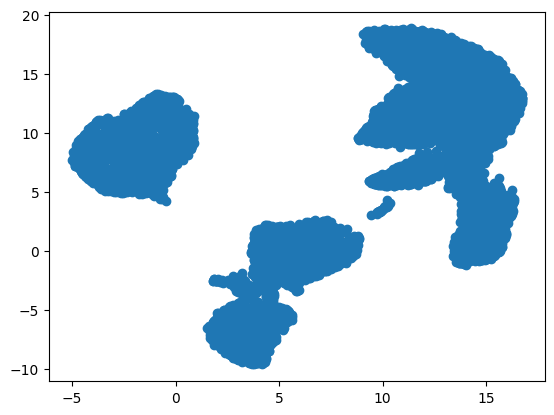

In [48]:
plt.scatter(l1[:,0], l1[:,1])

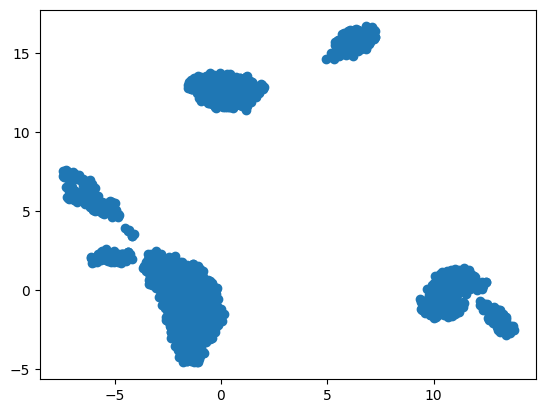

In [49]:
plt.scatter(l2[:,0], l2[:,1])

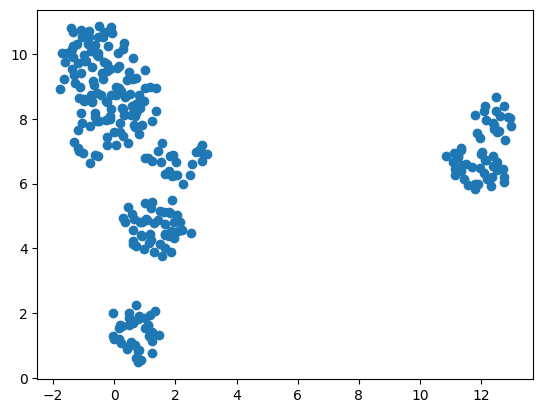

In [50]:
plt.scatter(l3[:,0], l3[:,1])